## Essa parte do código se torna relevante após execução de main.py - obtendo os registros com a busca, e inserindo em um banco de dados!

1. Problemas

In [42]:
import mysql.connector
import pandas as pd
import json
from rapidfuzz import fuzz, process
import csv
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
with open("config.json", "r", encoding="utf-8") as f:
    config = json.load(f)

db_config = {
    "host": config["db_host"],
    "user": config["db_user"],
    "password": config["db_password"],
    "database": config["db_schema"]
}

conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

print("conexão estabelecida")

# Considerando os seguintes problemas:

# • Missing values: escolher estratégias de imputação adequadas
# Observando o banco de dados atentamente, podemos ver que há vários casos de valores faltantes - no código de barras, por exemplo:

cursor.execute("""
SELECT COUNT(*) AS barcode_null
FROM registros_biodiversidade
WHERE barcode IS NULL OR barcode = '';
""")

df_barcode = pd.DataFrame(cursor.fetchall(), columns=['barcode_null'])
df_barcode


conexão estabelecida


,barcode_null
0,56452


In [ ]:


# O código de barras de uma exsicata é como se fosse o seu ID, sendo imprenscindível a necessidade de se ter um. No entanto,
# diferentemente de um ID comum, que poderíamos assignar um valor aleatório, o código de barras é ligado ao herbário que catalogou
# aquela planta, podendo ser uma informação importante nas nossas análises de dados. Portanto, optamos por "descartar" esses registros
# (não removeremos nada, apenas faremos um novo campo para armazenar instâncias que possuem um código de barras e utilizaremos ele como
# critério de filtragem para somente utilizarmos os registros que cumpram esse pré-requisito.)

# Outros campos do banco de dados não possuem registros, como o de país, estado, localidade, quem identificou esse nome científico
# à espécie...optamos por descartar todos esses registros também, seguindo o mesmo padrão da criação de um
# novo campo como fizemos com o código de barras.
cursor.execute("""
SELECT COUNT(*) AS pais_null
FROM registros_biodiversidade
WHERE country IS NULL OR country = '';
""")

df_country = pd.DataFrame(cursor.fetchall(), columns=['pais_null'])
df_country


,pais_null
0,798


In [35]:
cursor.execute("""
SELECT COUNT(*) AS estado_null
FROM registros_biodiversidade
WHERE stateprovince IS NULL OR stateprovince = '';
""")

df_state = pd.DataFrame(cursor.fetchall(), columns=['estado_null'])
df_state

# • Outliers: detectar valores extremos e decidir sobre tratamento
# No nosso banco de dados não possuímos muitos outliers. O mais próximo que possuiríamos disso seriam, por exemplos, registros que possuem
# um estado federativo brasileiro, mas o seu campo de país não está marcado como Brasil. Em casos como esses, decidimos atualizar o novo
# campo de país como sendo "Brasil", mantendo o registro no nosso acervo válido.

# • Inconsistências: verificar dependências entre variáveis (dependências funcionais, denialconstraints – se existirem) – verificar e corrigir possíveis erros.
# Até o dado momento, não verificamos inconsistências no nosso banco de dados. Caso encontremos alguma, faremos uma ressalva adicional
# com o veredito da ação que tomaremos.

# • Padronização: uniformizar formatos de datas, textos e códigos
# Nosso banco de dados precisa de muitas padronizações, pois por ter sido digitado manualmente pelos funcionários dos herbários para o
# acervo do SpeciesLink, ele possui muitos erros de digitação e variações de um nome (como por exemplo, Brazil e Brasil). Em casos como
# esses, padronizaremos o uso de um único nome.

,estado_null
0,24615


2. Padronizações

In [ ]:
# país: queremos somente valores brasileiros, considerando a nossa fauna local e as hipóteses que testaremos com as localidades futuramente.

# criando novo campo pra não excluir o country antigo
try:
    cursor.execute("""
        ALTER TABLE registros_biodiversidade
        ADD COLUMN country_att TEXT;
    """)
    print("'country_att' criado com sucesso")
except mysql.connector.Error as e:
    if "Duplicate column name" in str(e):
        print("'country_att' já existe")

cursor.close()
cursor = conn.cursor()

# selecionando todos os registros que possuem um campo de país não nulo, para groupby e avaliação manual dos nomes que se enquadram
cursor.execute("""
    SELECT country
    FROM registros_biodiversidade
    WHERE country IS NOT NULL AND country <> ''
    GROUP BY country
    ORDER BY country;
""")

df_countries = pd.DataFrame(cursor.fetchall(), columns=['country'])
df_countries.to_csv("countries_list.csv", index=False, encoding="utf-8")
print(f"{len(df_countries)} países exportados para 'countries_list.csv'")

# manualmente filtramos os registros que gostaríamos de countries_list, e conseguimos os seguintes valores que representavam o Brasil:

try:
    cursor.execute("""
        UPDATE registros_biodiversidade
        SET country_att = country
        WHERE country IN ("[Brésil]", "|Brasil", "Brasil", "Brasil/Bolivia", "Brasilia", "Brasill", "Brazil", "Brésil");
    """)
    conn.commit()
    print(f"registros atualizados com sucesso - ({cursor.rowcount} linhas alteradas)")
except mysql.connector.Error as e:
    print("erro:", e)

'country_att' criado com sucesso
85 países exportados para 'countries_list.csv'
registros atualizados com sucesso - (88089 linhas alteradas)


In [ ]:
# código de barras: como explicado anteriormente, é extremamente necessário
try:
    cursor.execute("""
        ALTER TABLE registros_biodiversidade
        ADD COLUMN barcode_att TEXT;
    """)
    print("'barcode_att' criado com sucesso")
except mysql.connector.Error as e:
    if "Duplicate column name" in str(e):
        print("'barcode_att' já existe")

cursor.close()
cursor = conn.cursor()

try:
    cursor.execute("""
        UPDATE registros_biodiversidade
        SET barcode_att = barcode
        WHERE barcode IS NOT NULL;
    """)
    conn.commit()
    print(f"registros atualizados com sucesso - ({cursor.rowcount} linhas alteradas)")
except mysql.connector.Error as e:
    print("erro:", e)

'barcode_att' criado com sucesso
registros atualizados com sucesso - (129165 linhas alteradas)


In [ ]:
# estado: gostaríamos de conseguir identificar de onde vem nossas exsicatas para uso futuro em hipoteses e perguntas
# seguimos o mesmo método de criaçao de um novo campo e atualizaçao a partir do antigo, considerando possiveis diferenças de escrita
# criando novo campo pra não excluir o stateprovince antigo
try:
    cursor.execute("""
        ALTER TABLE registros_biodiversidade
        ADD COLUMN stateprovince_att TEXT;
    """)
    print("'stateprovince_att' criado com sucesso")
except mysql.connector.Error as e:
    if "Duplicate column name" in str(e):
        print("'stateprovince_att' já existe")

cursor.close()
cursor = conn.cursor()

# selecionando todos os registros que possuem um campo de país não nulo, para groupby e avaliação manual dos nomes que se enquadram
cursor.execute("""
    SELECT stateprovince
    FROM registros_biodiversidade
    WHERE stateprovince IS NOT NULL AND stateprovince <> ''
    GROUP BY stateprovince
    ORDER BY stateprovince;
""")

df_stateprovince = pd.DataFrame(cursor.fetchall(), columns=['stateprovince'])
df_stateprovince.to_csv("stateprovince_list.csv", index=False, encoding="utf-8")
print(f"{len(df_stateprovince)} países exportados para 'stateprovince_list.csv'")

updates = {
    "Rio de Janeiro": ["Teresopolis", "Rio de Janeiro", "RJ", "Angra dos Reis", "Guanabara", "Rio de Janriro"],
    "Minas Gerais": ["Minas gerais", "Minas Gerais", "MG", "MINAS GERAIS, MG", "Minas Gerais.", "Santa Bárbara"],
    "Bahia": ["Bahia", "BA", "BAHIA, BA"],
    "Ceará": ["Ceará", "CE", "Ceara"],
    "Santa Catarina": ["Santa Catarina", "SC"],
    "Amazonas": ["Amazonas", "AM"],
    "Goiás": ["Goiás", "GO", "Goias"],
    "São Paulo": ["São Paulo", "SP", "Sao Paulo"],
    "Acre": ["Acre", "AC", "Rio Branco"],
    "Roraima": ["Roraima", "RR", "Roraima (?)", "Roraima (Terr.)"],
    "Paraná": ["Paraná", "PR", "Paraná ", "Santa Helena", "Parana"],
    "Rio Grande do Sul": ["Rio Grande do Sul", "RS", "Cerro Largo", "Vera Cruz"],
    "Mato Grosso": ["Mato Grosso", "MT"],
    "Espírito Santo": ["Espírito Santo", "ES", "ESPÍRITO SANTO, ES", "Ilha da Trindade", "Espirito Santo"],
    "Pernambuco": ["Pernambuco", "Fernando de Noronha", "PE", "Pernanbuco"],
    "Piauí": ["Piauí", "Piaui", "PI"],
    "Distrito Federal": ["Districto Federal - DF", "Distrito Federal", "DF", "Brasília", "Brasilia", "Distrito federal"],
    "Mato Grosso do Sul": ["Mato Grosso do Sul", "MS", "Bonito"],
    "Tocantins": ["Tocantins", "TO"],
    "Alagoas": ["Alagoas", "AL"],
    "Paraíba": ["Paraíba", "PB", "Paraiba"],
    "Sergipe": ["Sergipe", "SE"],
    "Rio Grande do Norte": ["Rio Grande do Norte", "Rio Grade do Norte", "Santa Cruz", "RN"],
    "Rondônia": ["Rondônia", "RO", "Rondonia (Terr.)", "Rondonia", "Rondônia (Terr.)"],
    "Amapá": ["Amapá", "AP", "Amapá (Terr.)", "Amapa", "Amapá (Terr.)"],
    "Maranhão": ["Maranhão", "MA", "Maranhao"],
    "Pará": ["Pará", "Pará ", "PA", "Para"]
}

for estado, variacoes in updates.items():
    try:
        placeholders = ", ".join(["%s"] * len(variacoes))
        query = f"""
            UPDATE registros_biodiversidade
            SET stateprovince_att = %s
            WHERE stateprovince IN ({placeholders});
        """
        cursor.execute(query, [estado] + variacoes)
        conn.commit()
        print(f"{estado}: {cursor.rowcount} linhas atualizadas")
    except mysql.connector.Error as e:
        print(f"erro no {estado}: {e}")

'stateprovince_att' criado com sucesso
408 países exportados para 'stateprovince_list.csv'
Rio de Janeiro: 7087 linhas atualizadas
Minas Gerais: 8334 linhas atualizadas
Bahia: 6756 linhas atualizadas
Ceará: 488 linhas atualizadas
Santa Catarina: 6211 linhas atualizadas
Amazonas: 7887 linhas atualizadas
Goiás: 2308 linhas atualizadas
São Paulo: 10381 linhas atualizadas
Acre: 2142 linhas atualizadas
Roraima: 897 linhas atualizadas
Paraná: 10809 linhas atualizadas
Rio Grande do Sul: 3467 linhas atualizadas
Mato Grosso: 2092 linhas atualizadas
Espírito Santo: 3810 linhas atualizadas
Pernambuco: 1229 linhas atualizadas
Piauí: 75 linhas atualizadas
Distrito Federal: 1666 linhas atualizadas
Mato Grosso do Sul: 1402 linhas atualizadas
Tocantins: 330 linhas atualizadas
Alagoas: 719 linhas atualizadas
Paraíba: 283 linhas atualizadas
Sergipe: 152 linhas atualizadas
Rio Grande do Norte: 3034 linhas atualizadas
Rondônia: 1533 linhas atualizadas
Amapá: 806 linhas atualizadas
Maranhão: 278 linhas atu

In [ ]:
# Outlier: possui stateprovince_att, mas não possui country_att, ou seja, é brasileiro mas por algum motivo foi marcado como não sendo
try:
    query = """
        UPDATE registros_biodiversidade
        SET country_att = 'Brasil'
        WHERE stateprovince_att IS NOT NULL;
    """
    cursor.execute(query)
    conn.commit()
    print(f"country_att atualizado para 'Brasil' em {cursor.rowcount} registros")
except mysql.connector.Error as e:
    print(f"erro: {e}")

country_att atualizado para 'Brasil' em 27102 registros


In [40]:
# taxonomistas: pessoas que trabalham em herbários e fazem a identificação taxonômica de uma dada espécime de uma família.
# para o nosso trabalho é importante saber se a pessoa que identificou esse nome é de confiança, pois futuramente tentaremos
# fazer a identificação taxonomica baseada em diversos testes. e de que adiantaria fazer isso se o nome estava incorreto desde o começo?
# escolhemos os top 10 identificadores, usando de uma comparação fuzzy para pegar nomes parecidos

cursor = conn.cursor()

cursor.execute("""
    SELECT identifiedby
    FROM registros_biodiversidade
    WHERE identifiedby IS NOT NULL
    AND country_att IS NOT NULL
    AND stateprovince_att IS NOT NULL
    AND barcode_att IS NOT NULL
""") # foram feitas restrições em cima dos outros dados anteriormente filtrados pois somente com identifiedby sendo não nulo tem 91 mil registros, fazendo o próximo passo demorar
rows = cursor.fetchall()

# converter para lista simples e limpar
names = [r[0].strip() for r in rows if r[0].strip() != ""]

similaridade = 80 
clusters = []
used = set()

for i, name in enumerate(names):
    if name in used: # se o nome ja foi visto antes em algum grupo
        continue
    group = [name] # adiciona em um grupo novo
    used.add(name) # marca nome como usado
    for other in names: # para todos os outros nomes 
        if other in used: # se ele já foi usado
            continue
        if fuzz.token_sort_ratio(name, other) >= similaridade: # comparamos o nome que originou um novo grupo a todos os outros nomes
            group.append(other)                                # se tiver similaridade o suficiente, adicionamos ao grupo
            used.add(other) # usado
    clusters.append(group) # guarda o cluster

    if i % 100 == 0: # printando só pra ver se não morreu porque tava demorando
        print(f"[{i}/{len(names)} | processando: '{name}'")

print("terminou de agrupar\n")

cluster_detalhado = []

for group in clusters:
    count = sum(names.count(n) for n in group)
    rep = max(group, key=lambda n: names.count(n))
    cluster_detalhado.append((rep, count, group))

# ordenar por frequência total
cluster_detalhado.sort(key=lambda x: x[1], reverse=True)

top_clusters = cluster_detalhado[:10] # pegar só o top 10
data_hierarquico = []

for rep, count, group in top_clusters:
    # nome principal e contagem
    row = [rep if rep.strip() != "" else "", count]
    # adicionar cada variação como coluna extra "nome", "nome", "nome"
    variacoes = [v for v in group if v != rep]
    row.extend(variacoes)
    data_hierarquico.append(row)

max_cols = max(len(r) for r in data_hierarquico)
columns = ["nome principal", "quantia"] + [f"variação {i}" for i in range(1, max_cols - 1)]
df_hierarquico = pd.DataFrame(data_hierarquico, columns=columns)

# salvar CSV com aspas em todos os campos
df_hierarquico.to_csv(
    "top10_taxonomistas_fuzzy.csv",
    index=False,
    encoding="utf-8-sig",
    quoting=csv.QUOTE_ALL
)

print("CSV salvo: top10_taxonomistas_fuzzy.csv")


[0/47457 | processando: '?'
[200/47457 | processando: 'D.Monteiro'
[3300/47457 | processando: 'Guimarães, E.; ferreira, D.M.'
[5800/47457 | processando: 'M.G. Rezende'
[6200/47457 | processando: 'Bloemer, HC'
[6400/47457 | processando: 'N.R. dos Santos'
[6600/47457 | processando: 'G.A.Damasceno-Junior'
[6800/47457 | processando: 'Gorenstein, M.R.'
[7200/47457 | processando: 'Carniello, MA; Amorim, PRF'
[8600/47457 | processando: 'J. B. Bringel'
[12200/47457 | processando: 'Luzia Francisca de Souza'
[14400/47457 | processando: 'Ferraz, JR'
[16900/47457 | processando: 'Amorim, A'
[18400/47457 | processando: 'J.Semir et R.Pereira'
[21900/47457 | processando: 'F. Bonadeu da Silva'
[22900/47457 | processando: 'Sarnaglia-Junior, B'
[27000/47457 | processando: 'MALINOWSKI, R.'
[29700/47457 | processando: 'Daniel Quedes'
[34700/47457 | processando: 'A.Rozza'
[35100/47457 | processando: 'I. G. Vargas (USZ)'
[37300/47457 | processando: 'Perazzolo, M. & Pereira, C.'
[43200/47457 | processando: 'L

In [ ]:
cursor.close()
cursor = conn.cursor()
# mesmo processo de novo campo
try:
    cursor.execute("""
        ALTER TABLE registros_biodiversidade
        ADD COLUMN identifiedby_att TEXT;
    """)
    print("'identifiedby_att' criado com sucesso")
except mysql.connector.Error as e:
    if "Duplicate column name" in str(e):
        print("'identifiedby_att' já existe")

cursor.close()
cursor = conn.cursor()

updates = {}

with open("top10_taxonomistas_fuzzy.csv", encoding="utf-8-sig") as f:
    reader = csv.reader(f)
    headers = next(reader)  # pular cabeçalho
    for row in reader:
        # nome principal = primeira coluna
        nome_principal = row[0].strip()
        # ignorar colunas vazias e remover possíveis aspas extras
        variacoes = [v.strip() for v in row[2:] if v.strip() != ""]
        updates[nome_principal] = variacoes

for nome_principal, variacoes in updates.items():
    nomes_para_atualizar = [nome_principal] + variacoes
    if not nomes_para_atualizar:
        continue  # pular caso não tenha nada
    try:
        placeholders = ", ".join(["%s"] * len(nomes_para_atualizar))
        query = f"""
            UPDATE registros_biodiversidade
            SET identifiedby_att = %s
            WHERE identifiedby IN ({placeholders});
        """
        cursor.execute(query, [nome_principal] + nomes_para_atualizar)
        conn.commit()
        print(f"{nome_principal}: {cursor.rowcount} linhas atualizadas")
    except mysql.connector.Error as e:
        print(f"erro em {nome_principal}: {e}")

cursor.close()
conn.close()

'identifiedby_att' criado com sucesso
Guimarães, EF: 8303 linhas atualizadas
Callejas, R: 6332 linhas atualizadas
Carvalho-Silva, M: 3074 linhas atualizadas
T. G. Yuncker: 2959 linhas atualizadas
R. Callejas Posada: 2566 linhas atualizadas
M. Carvalho-Silva: 1531 linhas atualizadas
D. Monteiro: 1733 linhas atualizadas
Machado-Silva, T.: 1053 linhas atualizadas
Marcusso, GM: 1107 linhas atualizadas
George Azevedo de Queiroz: 773 linhas atualizadas


3. Visualizações

In [ ]:
conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

# buscar todos os registros
cursor.execute("SELECT * FROM registros_biodiversidade")
rows = cursor.fetchall()

# pegar nomes exatos das colunas
columns = [desc[0] for desc in cursor.description]

# criar DataFrame
df = pd.DataFrame(rows, columns=columns)

# salvar CSV
df.to_csv("registros_biodiversidade.csv", index=False, encoding="utf-8-sig", quoting=1)  # quoting=1 = QUOTE_ALL

print(f"exportando {len(df)} linhas e {len(df.columns)} colunas para 'registros_biodiversidade.csv'")

# fechar conexões
cursor.close()
conn.close()

exportando 185617 linhas e 34 colunas para 'registros_biodiversidade.csv'


C:\Users\Dell\AppData\Local\Temp\ipykernel_93236\1489318965.py:1: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("registros_biodiversidade.csv", encoding="utf-8-sig")


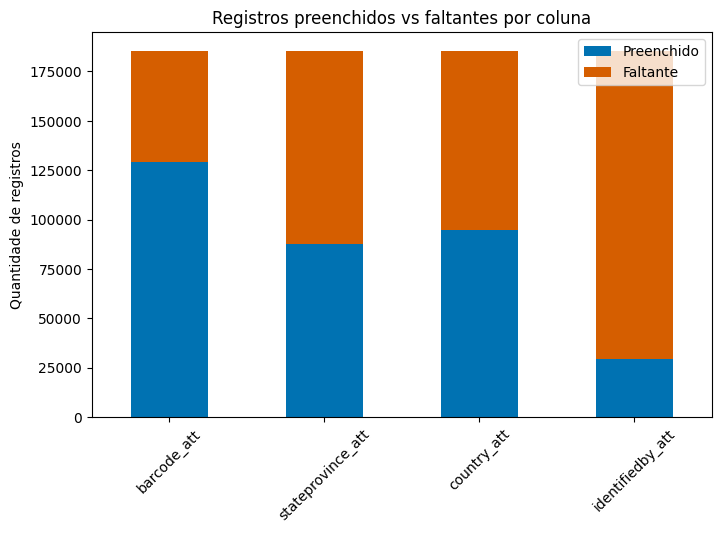

In [ ]:
df = pd.read_csv("registros_biodiversidade.csv", encoding="utf-8-sig")

# apenas as colunas que filtramos
cols = ["barcode_att", "stateprovince_att", "country_att", "identifiedby_att"]
filled_counts = df[cols].notnull().sum()
missing_counts = df[cols].isnull().sum()

df_plot = pd.DataFrame({
    "preenchido": filled_counts,
    "faltante": missing_counts
})

# queríamos fazer com heatmap, mas ficava tudo tão esticado com 180k de registros que fizemos um gráfico de barras empilhadas
df_plot.plot(kind="bar", stacked=True, figsize=(8,5), color=["#0072B2", "#D55E00"])
plt.ylabel("quantidade de registros")
plt.title("registros preenchidos vs faltantes por coluna")
plt.xticks(rotation=45)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_93236\1974238311.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tax_count.index, y=tax_count.values, palette="colorblind")


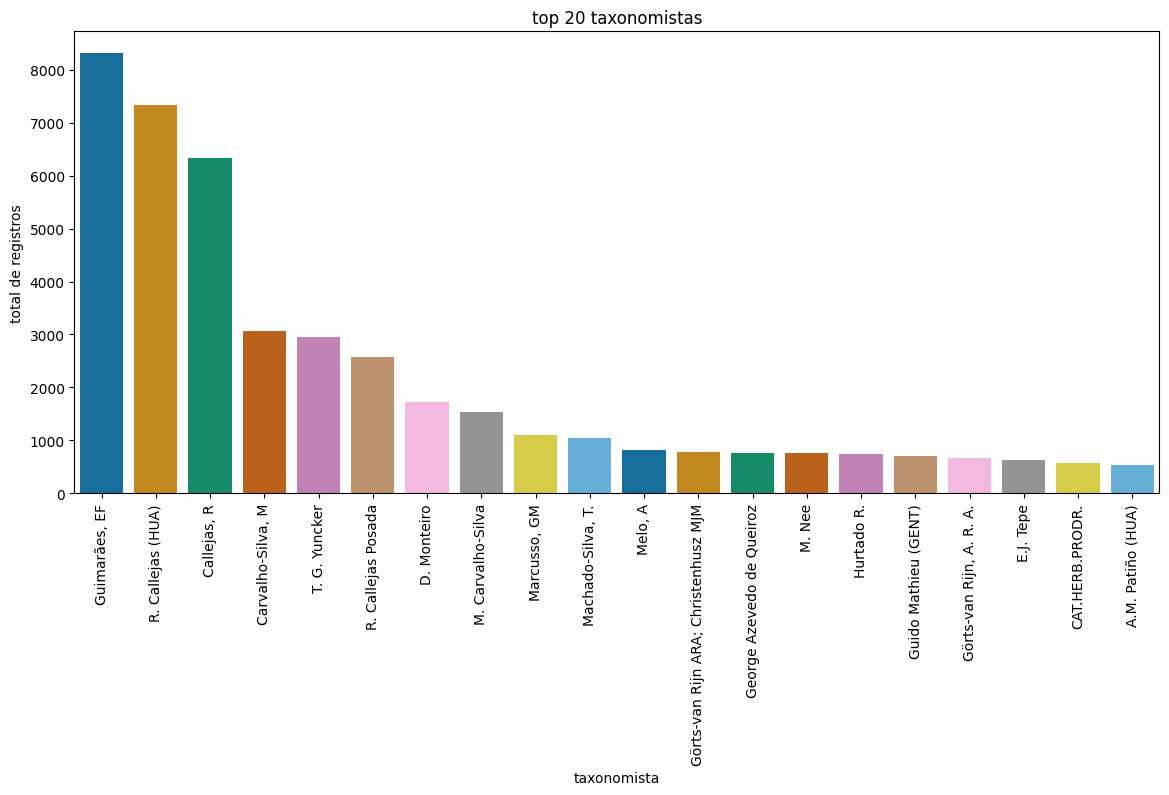

In [55]:
taxonomistas = df["identifiedby_att"].fillna(df["identifiedby"])  # usar coluna limpa se existir
tax_count = taxonomistas.value_counts().head(20)

plt.figure(figsize=(14, 6))
sns.barplot(x=tax_count.index, y=tax_count.values, palette="colorblind")
plt.xticks(rotation=90)
plt.ylabel("total de registros")
plt.xlabel("taxonomista")
plt.title("top 20 taxonomistas")
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_93236\946303506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["completude"] = df_subset.notnull().sum(axis=1)


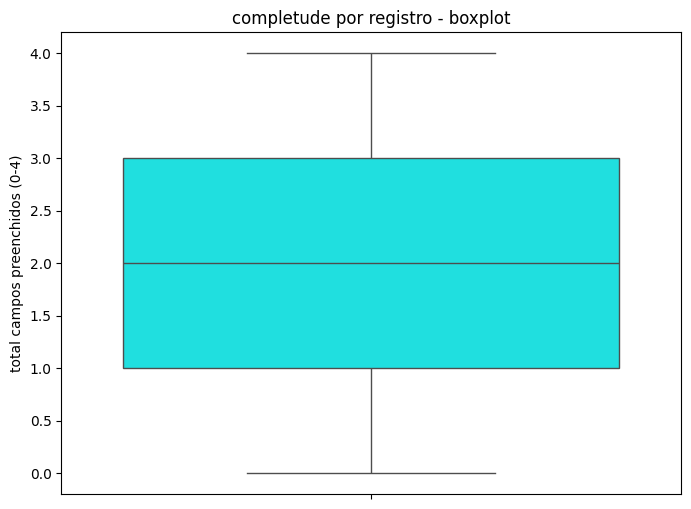

In [60]:
df_subset = df[cols]
df_subset["completude"] = df_subset.notnull().sum(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(y=df_subset["completude"], color="cyan")
plt.ylabel("total campos preenchidos (0-4)")
plt.title("completude por registro - boxplot")
plt.show()